# Mavlink Camera Walkthrough
>  Documentation 



In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
# skip_showdoc: true to avoid running cells when rendering docs, and skip_exec: true to skip this notebook when running tests. 
# this should be a raw cell 

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.showdoc import *
from fastcore.test import *


## Introduction
> Here we create an entire mavlink connection with client at the GCS and server at the camera. The client and server are connected via a UDP connection or a radio modem serial connection
> The camera can be controlled via the client, and the video stream is sent from the server to the client. The client can also request camera information, storage information, etc from the server.

In [ ]:
from mavcom.mavlink import CameraClient, CameraServer,  MAVCom, GimbalClient, GimbalServer, mavutil, mavlink
# from mavcom.mavlink.camera_client import CameraClient
# from mavcom.mavlink.camera_server import  CameraServer
# from mavcom.mavlink import Component, mavutil, mavlink, MAVCom
from mavcom.utils import boot_time_str, read_camera_dict_from_toml, find_config_dir
from mavcom.camera.gst_cam import GSTCamera    # fake camera for testing
from gstreamer import  GstPipeline
import gstreamer.utils as gst_utils
from mavcom.logging import LogLevels
from pathlib import Path
import cv2

Create a CameraClient and CameraServer

In [ ]:
MAV_TYPE_GCS = mavutil.mavlink.MAV_TYPE_GCS
MAV_TYPE_CAMERA = mavutil.mavlink.MAV_TYPE_CAMERA

Create a gstreamer pipelene to display the received video

Create Pysical camera object, here either CV2Camera or GSTCamera
The toml file contains the camera parameters, such as resolution, framerate, etc and also the gstreamer pipeline command to create the video streams.

In [ ]:

cam_gst_1 = GSTCamera(camera_dict=read_camera_dict_from_toml(find_config_dir() / "test_camera_info.toml"))
# cam_cv2_1 = CV2Camera(camera_dict=read_camera_dict_from_toml(find_config_dir() / "test_camera_info.toml"))

INFO   | mavcom.GSTCamera   | 38.075 | gst_cam.py:317 | MainThread         | GSTCamera Started
INFO   | pygst.GstPipeli | 38.086 | gst_tools.py:223 | MainThread         | Starting GstPipeline: videotestsrc  ! video/x-raw,width=1920,height=1080,framerate=30/1 ! tee name=t t. ! queue ! autovideosink t. ! queue leaky=2 ! intervideosink channel=channel_0 t. ! queue leaky=2 ! intervideosink channel=channel_1 t. ! queue leaky=2 ! videoconvert ! videorate drop-only=true ! intervideosink channel=channel_2 


John Doe                        


In [ ]:
SINK_PIPELINE = gst_utils.to_gst_string([
            'udpsrc port=5000 ! application/x-rtp, media=(string)video, clock-rate=(int)90000, encoding-name=(string)H264, payload=(int)96',
            'rtph264depay ! avdec_h264',
            'fpsdisplaysink',
            # 'autovideosink',
        ])

rcv_pipeline = GstPipeline(SINK_PIPELINE)     # Create a Gstreamer pipeline to display the received video on fpsdisplaysink

Create the client mavlink connection, this is mounted on the GCS

In [ ]:
# assert False

In [ ]:
# for the client, we use the udpin connection, you can use serial as an option i.e "/dev/ttyACM0", "/dev/ttyUSB0"
client = MAVCom("udpin:localhost:14445", source_system=111, loglevel=LogLevels.INFO)  

INFO   | mavcom.MAVCom      | 38.254 |  mavcom.py:393 | Thread-5 (listen)  | MAVLink Mav2: True, source_system: 111


Create the server mavlink connection, this is mounted on the UAV companion computer

In [ ]:
# for the server, we use the udpout connection, you can use serial as an option  "/dev/ttyUSB0"
server = MAVCom("udpout:localhost:14445", source_system=222) 

INFO   | mavcom.MAVCom      | 38.365 |  mavcom.py:393 | Thread-6 (listen)  | MAVLink Mav2: True, source_system: 222


Add the camera client to the client mavlink connection

In [ ]:
cam = client.add_component(CameraClient(mav_type=mavlink.MAV_TYPE_GCS, source_component=11))

INFO   | mavcom.CameraClien | 38.404 | component.py:135 | MainThread         | Component Started self.source_component = 11, self.mav_type = 6, self.source_system = 111


Add the camera server to the server mavlink connection

In [ ]:
server.add_component(CameraServer(mav_type=mavlink.MAV_TYPE_CAMERA, source_component=mavlink.MAV_COMP_ID_CAMERA, camera=cam_gst_1))

INFO   | mavcom.CameraServe | 38.418 | component.py:135 | MainThread         | Component Started self.source_component = 100, self.mav_type = 30, self.source_system = 222


<CameraServer>

Wait for the heartbeat from the camera server

In [ ]:
%autoawait asyncio
async def doit():
    ret = await cam.wait_heartbeat(remote_mav_type=mavlink.MAV_TYPE_CAMERA)
    print(f"Heartbeat received {ret = }")
await doit()


Heartbeat received ret = (222, 100)


Set the target system and component for the camera client
and request camera information, storage information, camera capture status, and camera settings

In [ ]:
%autoawait asyncio
async def doit():
    msg = await cam.request_message(mavlink.MAVLINK_MSG_ID_CAMERA_INFORMATION, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
    print (f"1 MAVLINK_MSG_ID_CAMERA_INFORMATION {msg }")
    msg = await cam.request_message(mavlink.MAVLINK_MSG_ID_STORAGE_INFORMATION, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
    print (f"2 MAVLINK_MSG_ID_STORAGE_INFORMATION {msg }")
    msg = await cam.request_message(mavlink.MAVLINK_MSG_ID_CAMERA_CAPTURE_STATUS, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
    print (f"3 MAVLINK_MSG_ID_CAMERA_CAPTURE_STATUS {msg }")
    msg = await cam.request_message(mavlink.MAVLINK_MSG_ID_CAMERA_SETTINGS, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
    print (f"4 MAVLINK_MSG_ID_CAMERA_SETTINGS {msg }")
await doit()

1 MAVLINK_MSG_ID_CAMERA_INFORMATION CAMERA_INFORMATION {time_boot_ms : 520, vendor_name : John Doe, model_name : Fake Camera, firmware_version : 1, focal_length : 8.0, sensor_size_h : 6.0, sensor_size_v : 4.0, resolution_h : 1920, resolution_v : 1080, lens_id : 0, flags : 0, cam_definition_version : 1, cam_definition_uri : http://example.com/camera_definition.xml, gimbal_device_id : 0}
2 MAVLINK_MSG_ID_STORAGE_INFORMATION STORAGE_INFORMATION {time_boot_ms : 621, storage_id : 0, storage_count : 1, status : 0, total_capacity : 100000000.0, used_capacity : 0.0, available_capacity : 100000000.0, read_speed : 0.0, write_speed : 0.0, type : 0, name : }
3 MAVLINK_MSG_ID_CAMERA_CAPTURE_STATUS CAMERA_CAPTURE_STATUS {time_boot_ms : 722, image_status : 0, video_status : 0, image_interval : 0.0, recording_time_ms : 0, available_capacity : 0.0, image_count : 0}
4 MAVLINK_MSG_ID_CAMERA_SETTINGS CAMERA_SETTINGS {time_boot_ms : 824, mode_id : 0, zoomLevel : 0.0, focusLevel : 0.0}


Start an image capture seqeunce, and display the images as they arrive

In [ ]:
# cam.image_start_capture(interval=0.1, count=10)
# while cam_gst_1.capture_thread.is_alive():
#     if cam_gst_1.last_image is not None:
#         cv2.imshow('gst_src', cam_gst_1.last_image)
#         cam_gst_1.last_image = None
#     cv2.waitKey(10)

AssertionError: call set_target(target_system, target_component) first

Shutdown the receive pipeline and close the mavlink connections

In [ ]:
rcv_pipeline.shutdown()
client.close()
server.close()
cv2.destroyAllWindows()

In [ ]:
#| hide
# assert False

Perform the same test, but with the CV2Camera all in one cell

INFO   | mavcom.GSTCamera   | 16.334 | gst_cam.py:317 | MainThread         | GSTCamera Started
INFO   | pygst.GstPipeli | 16.405 | gst_tools.py:223 | MainThread         | Starting GstPipeline: videotestsrc  ! video/x-raw,width=1920,height=1080,framerate=30/1 ! tee name=t t. ! queue ! autovideosink t. ! queue leaky=2 ! intervideosink channel=channel_0 t. ! queue leaky=2 ! intervideosink channel=channel_1 t. ! queue leaky=2 ! videoconvert ! videorate drop-only=true ! intervideosink channel=channel_2 
INFO   | pygst.GstPipeli | 16.416 | gst_tools.py:223 | MainThread         | Starting GstPipeline: udpsrc port=5000 ! application/x-rtp, media=(string)video, clock-rate=(int)90000, encoding-name=(string)H264, payload=(int)96 ! rtph264depay ! avdec_h264 ! fpsdisplaysink
INFO   | mavcom.MAVCom      | 16.518 |  mavcom.py:393 | Thread-47 (listen) | MAVLink Mav2: True, source_system: 111


boot_time_str ='2023-10-15|12:07:37'
John Doe                        


INFO   | mavcom.MAVCom      | 16.620 |  mavcom.py:393 | Thread-48 (listen) | MAVLink Mav2: True, source_system: 222
INFO   | mavcom.CameraClien | 16.622 | component.py:135 | MainThread         | Component Started self.source_component = 11, self.mav_type = 6, self.source_system = 111
INFO   | mavcom.CameraServe | 16.624 | component.py:135 | MainThread         | Component Started self.source_component = 100, self.mav_type = 30, self.source_system = 222


Heartbeat received ret = (222, 100)
1 MAVLINK_MSG_ID_CAMERA_INFORMATION CAMERA_INFORMATION {time_boot_ms : 158802, vendor_name : John Doe, model_name : Fake Camera, firmware_version : 1, focal_length : 8.0, sensor_size_h : 6.0, sensor_size_v : 4.0, resolution_h : 1920, resolution_v : 1080, lens_id : 0, flags : 0, cam_definition_version : 1, cam_definition_uri : http://example.com/camera_definition.xml, gimbal_device_id : 0}
2 MAVLINK_MSG_ID_STORAGE_INFORMATION STORAGE_INFORMATION {time_boot_ms : 158904, storage_id : 0, storage_count : 1, status : 0, total_capacity : 100000000.0, used_capacity : 662987.0, available_capacity : 99337016.0, read_speed : 0.0, write_speed : 0.0, type : 0, name : }
3 MAVLINK_MSG_ID_CAMERA_CAPTURE_STATUS CAMERA_CAPTURE_STATUS {time_boot_ms : 159906, image_status : 1, video_status : 0, image_interval : 0.20000000298023224, recording_time_ms : 0, available_capacity : 0.0, image_count : 10}


WARNIN | mavcom.CameraClien | 19.835 | component.py:261 | MainThread         | **** ACK not handled MAV_CMD_REQUEST_MESSAGE:512 from : 222/100 COMMAND_ACK {command : 512, result : 0, progress : 0, result_param2 : 0, target_system : 111, target_component : 11}
WARNIN | mavcom.CameraClien | 19.837 | component.py:263 | MainThread         |       command_id = MAV_CMD_REQUEST_MESSAGE msg.get_srcSystem() = 222, target_system = 222,  msg.get_srcComponent() = 100, target_component = 100
WARNIN | mavcom.CameraClien | 19.838 | component.py:261 | MainThread         | **** ACK not handled MAV_CMD_REQUEST_MESSAGE:512 from : 222/100 COMMAND_ACK {command : 512, result : 0, progress : 0, result_param2 : 0, target_system : 111, target_component : 11}
WARNIN | mavcom.CameraClien | 19.839 | component.py:263 | MainThread         |       command_id = MAV_CMD_REQUEST_MESSAGE msg.get_srcSystem() = 222, target_system = 222,  msg.get_srcComponent() = 100, target_component = 100
WARNIN | mavcom.CameraClien | 19

4 MAVLINK_MSG_ID_CAMERA_SETTINGS CAMERA_SETTINGS {time_boot_ms : 160908, mode_id : 0, zoomLevel : 0.0, focusLevel : 0.0}
ret = False


INFO   | mavcom.GSTCamera   | 20.127 | gst_cam.py:541 | Thread-53 (_launch | Image saved to memory filesystem with name: 2023-10-15|12:10:20_0011.jpg
INFO   | mavcom.GSTCamera   | 20.129 | gst_cam.py:541 | Thread-54 (_launch | Image saved to memory filesystem with name: 2023-10-15|12:10:20_0001.jpg
INFO   | mavcom.GSTCamera   | 20.377 | gst_cam.py:541 | Thread-53 (_launch | Image saved to memory filesystem with name: 2023-10-15|12:10:20_0012.jpg
INFO   | mavcom.GSTCamera   | 20.379 | gst_cam.py:541 | Thread-54 (_launch | Image saved to memory filesystem with name: 2023-10-15|12:10:20_0002.jpg
INFO   | mavcom.GSTCamera   | 20.627 | gst_cam.py:541 | Thread-53 (_launch | Image saved to memory filesystem with name: 2023-10-15|12:10:20_0013.jpg
INFO   | mavcom.GSTCamera   | 20.629 | gst_cam.py:541 | Thread-54 (_launch | Image saved to memory filesystem with name: 2023-10-15|12:10:20_0003.jpg
INFO   | mavcom.GSTCamera   | 20.877 | gst_cam.py:541 | Thread-53 (_launch | Image saved to memory f

file = '/2023-10-15|12:10:19_0000.jpg', img.shape = (480, 640, 3)
file = '/2023-10-15|12:10:20_0001.jpg', img.shape = (480, 640, 3)
file = '/2023-10-15|12:10:20_0002.jpg', img.shape = (480, 640, 3)
file = '/2023-10-15|12:10:20_0003.jpg', img.shape = (480, 640, 3)
file = '/2023-10-15|12:10:20_0004.jpg', img.shape = (480, 640, 3)
5 MAVLINK_MSG_ID_STORAGE_INFORMATION STORAGE_INFORMATION {time_boot_ms : 163046, storage_id : 0, storage_count : 1, status : 0, total_capacity : 100000000.0, used_capacity : 116104.0, available_capacity : 99883896.0, read_speed : 0.0, write_speed : 0.0, type : 0, name : }


INFO   | pygst.GstPipeli | 21.806 | gst_tools.py:306 | MainThread         | GstPipeline Shutdown
INFO   | mavcom.GSTCamera   | 21.807 | gst_cam.py:485 | MainThread         | GSTCamera closed
INFO   | mavcom.CameraServe | 22.631 | component.py:404 | MainThread         | CameraServer closed
INFO   | mavcom.MAVCom      | 22.632 |  mavcom.py:442 | MainThread         | MAVCom  closed
INFO   | mavcom.CameraClien | 23.629 | component.py:404 | MainThread         | CameraClient closed
INFO   | mavcom.MAVCom      | 23.631 |  mavcom.py:442 | MainThread         | MAVCom  closed
INFO   | pygst.GstPipeli | 23.691 | gst_tools.py:306 | MainThread         | GstPipeline Shutdown


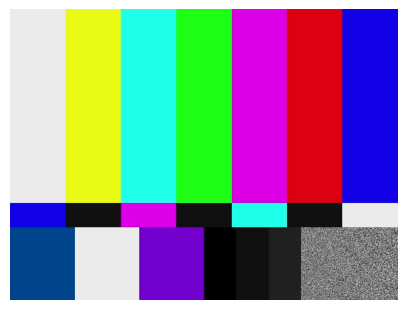

In [ ]:
from mavcom.utils.display import show_image
from mavcom.logging import LogLevels

from mavcom.mavlink import CameraClient, CameraServer,  MAVCom, GimbalClient, GimbalServer, mavutil, mavlink
from mavcom.utils.general import boot_time_str, With, read_camera_dict_from_toml, find_config_dir

from mavcom.camera.gst_cam import GSTCamera
from gstreamer import GstPipeline, Gst, GstContext, GstPipes
import gstreamer.utils as gst_utils
import cv2
import time
from pathlib import Path
import asyncio

SINK_PIPELINE = gst_utils.to_gst_string([
            'udpsrc port=5000 ! application/x-rtp, media=(string)video, clock-rate=(int)90000, encoding-name=(string)H264, payload=(int)96',
            'rtph264depay ! avdec_h264',
            'fpsdisplaysink',
            # 'autovideosink',
        ])
con1, con2 = "udpin:localhost:14445", "udpout:localhost:14445"
# con1, con2 = "/dev/ttyACM0", "/dev/ttyUSB0"

print (f"{boot_time_str =}")

cam_uav = GSTCamera(camera_dict=read_camera_dict_from_toml(find_config_dir() / "test_camera_info.toml"))
# cam_uav = CV2Camera(camera_dict=read_camera_dict_from_toml(find_config_dir() / "test_camera_info.toml"))

async def doit ():
    # with GstContext():  # GST main loop in thread
    with GstContext(), GstPipeline(SINK_PIPELINE):     # Create a Gstreamer pipeline to display the received video on fpsdisplaysink
        with MAVCom(con1, source_system=111) as client:
            with MAVCom(con2, source_system=222) as server:
                gcs = client.add_component(CameraClient(mav_type=mavlink.MAV_TYPE_GCS, source_component=11))
                server.add_component(CameraServer(camera=cam_uav, source_component=mavlink.MAV_COMP_ID_CAMERA))
                # server.add_component(CameraServer(mav_type=MAV_TYPE_CAMERA, source_component=22, camera=None, debug=False))
    
                ret = await gcs.wait_heartbeat(remote_mav_type=mavlink.MAV_TYPE_CAMERA)
                print(f"Heartbeat received {ret = }")
                time.sleep(0.1)
                msg = await gcs.request_message(mavlink.MAVLINK_MSG_ID_CAMERA_INFORMATION, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
                print (f"1 MAVLINK_MSG_ID_CAMERA_INFORMATION {msg }")
                msg = await gcs.request_message(mavlink.MAVLINK_MSG_ID_STORAGE_INFORMATION, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
                print (f"2 MAVLINK_MSG_ID_STORAGE_INFORMATION {msg }")
                msg = await gcs.request_message(mavlink.MAVLINK_MSG_ID_CAMERA_CAPTURE_STATUS, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
                print (f"3 MAVLINK_MSG_ID_CAMERA_CAPTURE_STATUS {msg }")
                msg = await gcs.request_message(mavlink.MAVLINK_MSG_ID_CAMERA_SETTINGS, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
                print (f"4 MAVLINK_MSG_ID_CAMERA_SETTINGS {msg }")
    
                ret = await gcs.image_start_capture(222, mavlink.MAV_COMP_ID_CAMERA, interval=0.2, count=5)
                print(f"{ret = }")
                
                time.sleep(1)
                for file in cam_mavcom.list_files():
                    if file.endswith(".jpg"):
                        img = cam_mavcom.load_image_from_memoryfs(file)
                        print (f"{file = }, {img.shape = }")

                lastimg = img
                show_image(lastimg, rgb2bgr=True)
                # start = time.time()
                msg = await gcs.request_message(mavlink.MAVLINK_MSG_ID_STORAGE_INFORMATION, target_system=222, target_component=mavlink.MAV_COMP_ID_CAMERA)
                print(f"5 MAVLINK_MSG_ID_STORAGE_INFORMATION {msg}")
                # time.sleep(5)

    
await doit()
